A Multi-Mechanism Astrocytic-Neuronal Model
Select experiment to run:
1: Phase 1 Baseline (Go/NoGo)
2: Phase 4, Exp 1 (Fear Generalization)
3: Phase 4, Exp 2 (Pathological Moods)
Running Experiment: Phase 1 Baseline


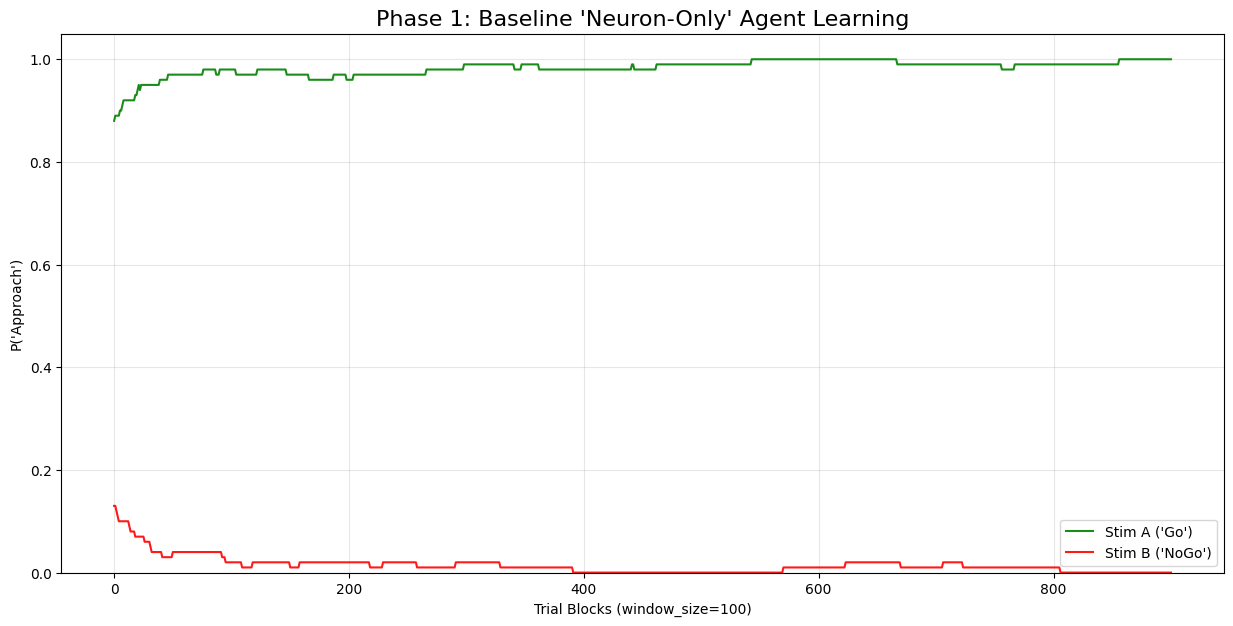

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt

################################################################################
##
## 🔬 PHASE 1-3: THE INTEGRATED AGENT
##
################################################################################

class AstrocyteNeuronAgent:
    """
    Implements the full, integrated Tri-Partite Model (Phases 1, 2, 3).
    This single class is modular and controlled by the 'config' dictionary.
    """
    
    def __init__(self, states, actions, config):
        # --- Store config
        self.config = config
        
        # --- Standard RL Parameters (Phase 1) ---
        self.alpha_g = config.get('alpha_g', 0.1) # Base learning rate for G
        self.alpha_n = config.get('alpha_n', 0.1) # Base learning rate for N
        self.alpha_v = config.get('alpha_v', 0.1) # Base learning rate for V (Critic)
        self.gamma = config.get('gamma', 0.95)    # Discount factor
        self.beta = config.get('beta', 1.0)       # Softmax temperature
        
        # --- State/Action Info ---
        self.states = states
        self.actions = actions
        
        # --- Phase 1 "Brain": Critic + Actor ---
        self.V = {state: 0.0 for state in self.states + ['End']}
        self.G = {state: {action: 0.0 for action in self.actions} for state in self.states}
        self.N = {state: {action: 0.0 for action in self.actions} for state in self.states}

        # --- Phase 2: Astrocyte Module Parameters & Variables ---
        
        # Module 1: Glutamate Clearance (The "Temporal Filter")
        self.use_glutamate_filter = config.get('use_glutamate_filter', False)
        self.astro_clearance_rate = config.get('astro_clearance_rate', 1.0) # 1.0 = instant, 0.1 = slow
        self.Perceived_State = {state: 0.0 for state in self.states}
        # Initialize perception for the *first* state
        if self.states:
             self.Perceived_State[self.states[0]] = 1.0

        # Module 2: Gliotransmitter Release (The "Learning Rate" Modulator)
        self.use_learning_modulator = config.get('use_learning_modulator', False)
        self.D_Serine_Level = config.get('D_Serine_Level', 1.0) # Manual override

        # Module 3: Calcium Dynamics (The "RPE-to-Glia" Link)
        self.use_rpe_to_glia_link = config.get('use_rpe_to_glia_link', False)
        self.Astro_Ca_Level = 0.0
        self.ATP_Level = 0.0
        self.astro_decay_ca = config.get('astro_decay_ca', 0.1) # Ca decay rate
        self.astro_decay_atp = config.get('astro_decay_atp', 0.05) # ATP decay (slower)
        self.astro_rpe_sensitivity_k = config.get('astro_rpe_sensitivity_k', 0.5) # RPE -> Ca
        self.astro_ca_to_atp_c = config.get('astro_ca_to_atp_c', 0.5) # Ca -> ATP

        # Phase 3: The Integrated "Tri-Partite" Model Link
        self.use_full_feedback_loop = config.get('use_full_feedback_loop', False)

    def _softmax(self, values):
        """Computes softmax probabilities for a list of values."""
        scaled_values = np.array(values) * self.beta
        prefs = scaled_values - np.max(scaled_values)
        exp_prefs = np.exp(prefs)
        return exp_prefs / np.sum(exp_prefs)

    def _get_effective_alphas(self):
        """Returns the learning rates, modulated by astrocyte state."""
        
        # Phase 3 Link: If loop is on, ATP drives D-Serine
        if self.use_full_feedback_loop:
            # Simple model: ATP adds to a baseline level
            self.D_Serine_Level = 1.0 + self.ATP_Level
        
        # Module 2: If modulator is on, D-Serine scales learning
        if self.use_learning_modulator or self.use_full_feedback_loop:
            alpha_g_eff = self.alpha_g * self.D_Serine_Level
            alpha_n_eff = self.alpha_n * self.D_Serine_Level
            return alpha_g_eff, alpha_n_eff
        else:
            return self.alpha_g, self.alpha_n

    def _update_glial_variables(self, rpe):
        """
        Updates Astrocyte Ca2+ and ATP levels based on RPE.
        d(Ca)/dt = -decay_ca * Ca + k * abs(RPE)
        d(ATP)/dt = -decay_atp * ATP + c * Ca
        """
        if not self.use_rpe_to_glia_link:
            return

        # Discrete Euler update for Ca Level
        dCa = (-self.astro_decay_ca * self.Astro_Ca_Level) + (self.astro_rpe_sensitivity_k * abs(rpe))
        self.Astro_Ca_Level += dCa
        
        # Discrete Euler update for ATP Level
        dATP = (-self.astro_decay_atp * self.ATP_Level) + (self.astro_ca_to_atp_c * self.Astro_Ca_Level)
        self.ATP_Level += dATP
        
        # Ensure levels are non-negative
        self.Astro_Ca_Level = max(0, self.Astro_Ca_Level)
        self.ATP_Level = max(0, self.ATP_Level)

    def perceive(self, true_state):
        """
        Module 1: Updates the agent's internal Perceived_State vector.
        d(P_S)/dt = -clearance_rate * P_S + Input
        """
        Input_vector = {s: (1.0 if s == true_state else 0.0) for s in self.states}
        
        if not self.use_glutamate_filter:
            # No filter: Perception is perfect and instant.
            self.Perceived_State = Input_vector
            return

        # With filter: Leaky integrator update
        for s in self.states:
            old_perception = self.Perceived_State[s]
            input_signal = Input_vector[s]
            
            # dP = (-clearance * P) + (clearance * Input)
            # This is a stable discrete form:
            # P(t) = (1-rate)*P(t-1) + rate*Input(t)
            # A rate of 1.0 means P(t) = Input(t) (instant)
            # A rate of 0.1 means P(t) = 0.9*P(t-1) + 0.1*Input(t) (slow)
            self.Perceived_State[s] = (1 - self.astro_clearance_rate) * old_perception + \
                                      self.astro_clearance_rate * input_signal

    def choose_action(self):
        """
        Chooses an action based on the *internal* Perceived_State.
        Calculates Q(a) = G(a) - N(a) by weighting the "true" state
        values by the "perceived" state probabilities.
        """
        action_scores = []
        for action in self.actions:
            # Calculate the perceived G and N by summing across all "blurry" states
            perceived_g = sum(self.Perceived_State[s] * self.G[s][action] for s in self.states)
            perceived_n = sum(self.Perceived_State[s] * self.N[s][action] for s in self.states)
            action_scores.append(perceived_g - perceived_n)
            
        probabilities = self._softmax(action_scores)
        chosen_action = random.choices(self.actions, weights=probabilities, k=1)[0]
        return chosen_action

    def update(self, action, reward, next_state):
        """
        Updates the agent's brain (V, G, N) and glial state (Ca, ATP)
        based on the last experience.
        """
        
        # --- 1. Critic Calculates RPE (based on perception) ---
        # V(perceived) = sum( P(s) * V(s) )
        V_perceived = sum(self.Perceived_State[s] * self.V[s] for s in self.states)
        V_next = self.V[next_state] # V('End') = 0
        rpe = reward + self.gamma * V_next - V_perceived
        
        # --- 2. Glial Modules React (The new step) ---
        # Get modulated learning rates
        alpha_g_eff, alpha_n_eff = self._get_effective_alphas()
        
        # Update Ca/ATP levels based on the RPE
        self._update_glial_variables(rpe)
        
        # --- 3. Critic & Actor Update (weighted by perception) ---
        # The RPE is "blamed" on states proportional to their perception
        for s in self.states:
            # Critic Update
            self.V[s] = self.V[s] + self.alpha_v * rpe * self.Perceived_State[s]
            
            # Actor Update
            if rpe > 0:
                self.G[s][action] = self.G[s][action] + alpha_g_eff * rpe * self.Perceived_State[s]
            elif rpe < 0:
                self.N[s][action] = self.N[s][action] + alpha_n_eff * abs(rpe) * self.Perceived_State[s]

        # Return RPE and glial levels for logging
        return rpe, self.Astro_Ca_Level, self.ATP_Level


################################################################################
##
## 🎯 PHASE 1: "NEURON-ONLY" BASELINE EXPERIMENT
##
################################################################################

def run_experiment_baseline(n_trials=2000):
    """
    Runs the Phase 1 Go/NoGo task to verify the 'neuron-only' baseline.
    """
    print("Running Experiment: Phase 1 Baseline")
    
    # Define states and actions for this task
    states = ['Stim_A', 'Stim_B']
    actions = ['Approach', 'Avoid']
    
    # The 'config' dictionary is the "control panel"
    config_baseline = {
        'use_glutamate_filter': False, # MODULE 1 OFF
        'use_learning_modulator': False, # MODULE 2 OFF
        'use_rpe_to_glia_link': False, # MODULE 3 OFF
        'use_full_feedback_loop': False,
        'alpha_g': 0.1,
        'alpha_n': 0.1,
        'alpha_v': 0.1,
        'beta': 2.0 # Higher beta for clearer choice preference
    }
    
    agent = AstrocyteNeuronAgent(states, actions, config=config_baseline)
    
    stim_A_choices = [] # 1 for 'Approach', 0 for 'Avoid'
    stim_B_choices = [] # 1 for 'Approach', 0 for 'Avoid'
    
    for trial in range(n_trials):
        true_state = 'Stim_A' if trial % 2 == 0 else 'Stim_B'
        
        # 1. Agent perceives the state (instant/perfect)
        agent.perceive(true_state)
        
        # 2. Agent makes a choice
        action = agent.choose_action()
        
        # 3. Environment gives a reward
        reward = 0
        if true_state == 'Stim_A' and action == 'Approach':
            if random.random() < 0.7: reward = 1 # 70% chance of +1
        elif true_state == 'Stim_B' and action == 'Approach':
            if random.random() < 0.7: reward = -1 # 70% chance of -1
        # 'Avoid' always gives 0 reward
        
        # 4. Agent learns
        agent.update(action, reward, 'End')
        
        # Log choices
        if true_state == 'Stim_A':
            stim_A_choices.append(1 if action == 'Approach' else 0)
        else:
            stim_B_choices.append(1 if action == 'Approach' else 0)
            
    # Plotting
    plot_moving_average(
        [stim_A_choices, stim_B_choices],
        window_size=100,
        labels=["Stim A ('Go')", "Stim B ('NoGo')"],
        colors=['green', 'red'],
        title="Phase 1: Baseline 'Neuron-Only' Agent Learning",
        y_label="P('Approach')"
    )

################################################################################
##
## 🔬 PHASE 4, EXP 1: FEAR GENERALIZATION
##
################################################################################

def run_experiment_fear_generalization(n_training=1000, n_extinction=1000):
    """
    Runs the Phase 4 'Fear Generalization' experiment.
    Compares a 'NeuronOnly' agent to a 'Pathological' agent.
    
    Task:
    - Phase A (Training): Context 1, Stim A -> Punishment
    - Phase B (Extinction): Context 2, Stim A -> No Reward (Safe)
    """
    print("Running Experiment: Fear Generalization (Glutamate Blur)")
    
    # States are now context-dependent
    states = ['Context1_StimA', 'Context2_StimA']
    actions = ['Approach', 'Avoid']
    
    # --- Config 1: Healthy "Neuron-Only" Agent ---
    config_healthy = {
        'use_glutamate_filter': True,  # Filter is ON
        'astro_clearance_rate': 1.0,   # BUT it's healthy (instant)
        'alpha_g': 0.1, 'alpha_n': 0.1, 'alpha_v': 0.1, 'beta': 2.0
    }
    
    # --- Config 2: Pathological "Glutamate Blur" Agent ---
    config_pathological = {
        'use_glutamate_filter': True,  # Filter is ON
        'astro_clearance_rate': 0.1,   # AND it's pathological (slow)
        'alpha_g': 0.1, 'alpha_n': 0.1, 'alpha_v': 0.1, 'beta': 2.0
    }
    
    agents = {
        "NeuronOnly (Healthy)": AstrocyteNeuronAgent(states, actions, config_healthy),
        "Astrocyte (Pathological)": AstrocyteNeuronAgent(states, actions, config_pathological)
    }
    
    results = {name: [] for name in agents}
    n_total_trials = n_training + n_extinction

    for agent_name, agent in agents.items():
        print(f"  Simulating {agent_name}...")
        for trial in range(n_total_trials):
            
            # --- Determine Phase & State ---
            if trial < n_training:
                phase = "Training"
                true_state = 'Context1_StimA'
            else:
                phase = "Extinction"
                true_state = 'Context2_StimA'
                
            # 1. Agent perceives the state
            agent.perceive(true_state)
            
            # 2. Agent makes a choice
            action = agent.choose_action()
            
            # 3. Environment gives a reward
            reward = 0
            if phase == "Training" and action == 'Approach':
                # In Context 1, 'Approach' is punished
                if random.random() < 0.8: reward = -1
            # In Context 2, it's safe (reward is always 0)
            
            # 4. Agent learns
            agent.update(action, reward, 'End')
            
            # 5. Log P(Approach) ONLY for the state that was presented
            if true_state == 'Context1_StimA':
                # During training, we only care about Context 1
                results[agent_name].append(1 if action == 'Approach' else 0)
            else:
                # During extinction, we only care about Context 2
                results[agent_name].append(1 if action == 'Approach' else 0)
                
    # Plotting
    plot_moving_average(
        [results["NeuronOnly (Healthy)"], results["Astrocyte (Pathological)"]],
        window_size=50,
        labels=["NeuronOnly (Healthy)", "Astrocyte (Pathological)"],
        colors=['blue', 'orange'],
        title="Experiment 1: Fear Generalization (Glutamate Blur)",
        y_label="P('Approach' Stim A)",
        v_lines=[n_training] # Add line for context switch
    )

################################################################################
##
## 🔬 PHASE 4, EXP 2: PATHOLOGICAL "MOODS"
##
################################################################################

def run_experiment_volatile_moods(n_trials=3000):
    """
    Runs the Phase 4 'Pathological Moods' experiment.
    Compares a 'NeuronOnly' agent to a 'Full-Feedback' agent.
    
    Task:
    - A single stimulus (Stim A) has a reward probability
      that slowly drifts over time.
    """
    print("Running Experiment: Pathological Moods (Feedback Loop)")
    
    states = ['Stim_A']
    actions = ['Approach', 'Avoid']
    
    # --- Config 1: Healthy "Neuron-Only" Agent ---
    config_healthy = {
        'use_glutamate_filter': False,
        'use_rpe_to_glia_link': False, # MODULE 3 OFF
        'use_full_feedback_loop': False, # LINK OFF
        'alpha_g': 0.1, 'alpha_n': 0.1, 'alpha_v': 0.1, 'beta': 2.0
    }
    
    # --- Config 2: Pathological "Feedback-Loop" Agent ---
    config_pathological = {
        'use_glutamate_filter': False,
        'use_rpe_to_glia_link': True,  # MODULE 3 ON
        'use_full_feedback_loop': True, # LINK ON
        'alpha_g': 0.1, 'alpha_n': 0.1, 'alpha_v': 0.1, 'beta': 2.0,
        # Glial parameters (tune these to get strong effects)
        'astro_decay_ca': 0.1,
        'astro_decay_atp': 0.05, # Slow decay is key
        'astro_rpe_sensitivity_k': 0.5, # Sensitive to RPE
        'astro_ca_to_atp_c': 0.5        # Strong coupling
    }
    
    agents = {
        "NeuronOnly (Healthy)": AstrocyteNeuronAgent(states, actions, config_healthy),
        "Astrocyte (Pathological)": AstrocyteNeuronAgent(states, actions, config_pathological)
    }
    
    # --- Setup the volatile environment ---
    # Probability of reward will follow a sine wave
    true_reward_probs = (np.sin(np.linspace(0, 8 * np.pi, n_trials)) * 0.4) + 0.5
    # This creates a probability that drifts from 0.5 up to 0.9, down to 0.1, etc.
    
    results = {name: {"choices": [], "alphas": [], "atp": []} for name in agents}
    
    for agent_name, agent in agents.items():
        print(f"  Simulating {agent_name}...")
        for trial in range(n_trials):
            true_state = 'Stim_A'
            
            # 1. Perceive
            agent.perceive(true_state)
            
            # 2. Choose
            action = agent.choose_action()
            
            # 3. Get Reward
            reward = 0
            prob = true_reward_probs[trial]
            if action == 'Approach':
                if random.random() < prob:
                    reward = 1  # Rewarding
                else:
                    reward = -1 # Punishing
            
            # 4. Learn
            rpe, ca, atp = agent.update(action, reward, 'End')
            
            # 5. Log
            results[agent_name]["choices"].append(1 if action == 'Approach' else 0)
            results[agent_name]["atp"].append(atp)
            # Get effective alpha_n for logging
            _, alpha_n_eff = agent._get_effective_alphas()
            results[agent_name]["alphas"].append(alpha_n_eff)

    # Plotting
    plot_volatile_experiment(results, true_reward_probs)

################################################################################
##
## 📊 PLOTTING HELPER FUNCTIONS
##
################################################################################

def plot_moving_average(data_list, window_size, labels, colors, title, y_label, v_lines=None):
    """
    Generic function to plot moving averages for one or more data series.
    """
    plt.figure(figsize=(15, 7))
    
    for i, data in enumerate(data_list):
        # Simple moving average
        moving_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
        plt.plot(moving_avg, label=labels[i], color=colors[i], alpha=0.9)

    if v_lines:
        for v_line in v_lines:
            plt.axvline(x=v_line - (window_size/2), color='grey', linestyle='--', warning=False, label="Phase Switch")
            
    plt.title(title, fontsize=16)
    plt.xlabel(f'Trial Blocks (window_size={window_size})')
    plt.ylabel(y_label)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_volatile_experiment(results, true_reward_probs):
    """
    Custom plotter for the 'Volatile Moods' experiment.
    """
    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    
    window = 100 # Moving average window
    
    # --- Plot 1: True Reward Probability ---
    axs[0].plot(true_reward_probs, label="True P(Reward | Approach)", color='black', linestyle=':')
    axs[0].set_title("Experiment 2: Pathological 'Moods' (Feedback Loop)", fontsize=16)
    axs[0].set_ylabel("True Reward Prob.")
    axs[0].grid(True, alpha=0.3)
    
    # --- Plot 2: Agent Choices (Moving Avg) ---
    for agent_name, res in results.items():
        avg_choice = np.convolve(res["choices"], np.ones(window)/window, mode='valid')
        color = 'blue' if 'Healthy' in agent_name else 'orange'
        axs[1].plot(avg_choice, label=agent_name, color=color)
    
    axs[1].set_ylabel("P('Approach') (Moving Avg)")
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    # --- Plot 3: Internal Glial State (Pathological Agent) ---
    atp_levels = results["Astrocyte (Pathological)"]["atp"]
    alpha_n_eff = results["Astrocyte (Pathological)"]["alphas"]
    
    ax3_twin = axs[2].twinx() # Create a twin y-axis
    
    # Plot ATP level on left axis
    axs[2].plot(atp_levels, label="Astrocyte ATP Level", color='purple', alpha=0.6)
    axs[2].set_xlabel("Trial")
    axs[2].set_ylabel("ATP Level (a.u.)", color='purple')
    
    # Plot effective alpha_n on right axis
    ax3_twin.plot(alpha_n_eff, label="Effective alpha_N", color='red', alpha=0.6)
    ax3_twin.set_ylabel(r'Effective $\alpha_N$ (Learning Rate)', color='red')
    
    axs[2].grid(True, alpha=0.3)
    
    fig.tight_layout()
    plt.show()


################################################################################
##
## 👟 MAIN EXECUTION
##
################################################################################

if __name__ == "__main__":
    
    print("A Multi-Mechanism Astrocytic-Neuronal Model")
    print("Select experiment to run:")
    print("1: Phase 1 Baseline (Go/NoGo)")
    print("2: Phase 4, Exp 1 (Fear Generalization)")
    print("3: Phase 4, Exp 2 (Pathological Moods)")
    
    # --- CHOOSE YOUR EXPERIMENT ---
    # Change this number to run a different experiment
    choice = 1
    # ------------------------------
    
    if choice == 1:
        run_experiment_baseline()
        
    elif choice == 2:
        run_experiment_fear_generalization()
        
    elif choice == 3:
        run_experiment_volatile_moods()
        
    else:
        print("Invalid choice. Please set 'choice' to 1, 2, or 3.")